# German Traffic Sign Classification using CNN

This notebook presents my approach to detecting traffic signs available in the ['German Traffic Sign Dataset'](http://benchmark.ini.rub.de/). The solution involves following highlevel steps:
* Exploring and visualizing the dataset
* Per-processing samples of the dataset
* Augmenting the training dataset
* Building a simple CNN classifier and training it
* Measuring it's accuracy

## Exploring the Dataset

In [2]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Basic statistics of the dataset

In [3]:
import numpy as np
import tensorflow as tf

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = max(y_train) +1

print("Number of training examples =", n_train)
print("Number of validation examples", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualizing the dataset: sample distribution across classes via histograms

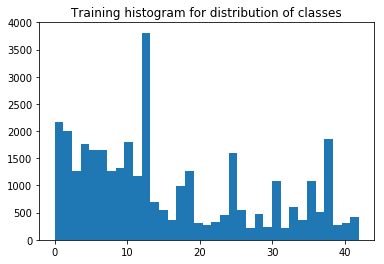

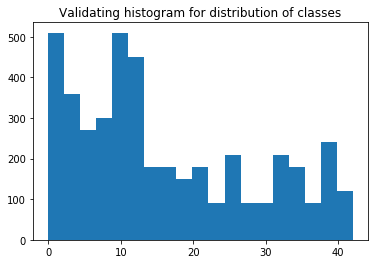

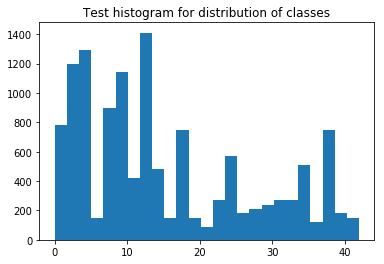

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
# to have the plots embeded in the notebook
%matplotlib inline 


plt.hist(y_train, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Training histogram for distribution of classes")
plt.show()

plt.hist(y_valid, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Validating histogram for distribution of classes")
plt.show()

plt.hist(y_test, bins='auto')  # plt.hist passes it's arguments to np.histogram
plt.title("Test histogram for distribution of classes")
plt.show()

### Visualizing a random sample from the training set

17


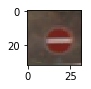

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])


### Pre-processing

Using CLAHE to pre-process the dataset

In [10]:
import cv2

# Helper function to substitute Y channel of an YUV image with a modified Y channel
def add_Y_to_UV(Y, img):
    img[:,:,0] = Y
    return img


#pre-processing with Contrast Limited Adaptive Histogram Equilization
def pre_process(img_array):
    clahe = cv2.createCLAHE()
    YUV_array = np.array([cv2.cvtColor(im, cv2.COLOR_RGB2YUV) for im in img_array])
    eqld_array = np.array([add_Y_to_UV(clahe.apply(im[:,:,0]), im) for im in YUV_array])
    pre_processed = np.array([cv2.cvtColor(im, cv2.COLOR_YUV2RGB) for im in eqld_array])
    return pre_processed.astype('float32')
 

In [11]:
# Pre-processing all training, validation and testing datasets

X_train_preprocessed = pre_process(X_train)
X_valid_preprocessed = pre_process(X_valid)
X_test_preprocessed = pre_process(X_test)

### Visuallizing the effect of pre-processing: befor and after comparison

Text(0.5,1,'after')

/home/pmsilva/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


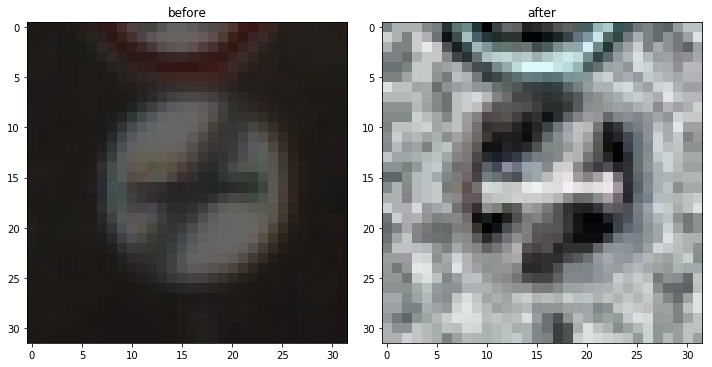

In [12]:
fig = plt.figure(figsize=(10,10), tight_layout={'h_pad':3})

#before pre-processing
sp = fig.add_subplot(1,2,1)
im = X_train[6].squeeze()
plt.imshow(im)
sp.set_title('before')

#after pre-processing
sp = fig.add_subplot(1,2,2)
im_pp = X_train_preprocessed[6].squeeze()
plt.imshow(im_pp)
sp.set_title('after')

### Data augmentation

Data augmentation is used for two reasons:
* Balance the uneven distribution of samples in the training dataset across classes
* Add variance to the training dataset, that is not captured from a relatively small dataset like 35K. This helps to genaralize the training set to represent all possible inputs to the network

To quantify the uneven distribution of the training set, lets print number of samples found per each class 

In [13]:
def print_hist(x,y):
    print('sample distribution among classes.....')
    for c in range(n_classes):
        n_samples_of_c = len(y[y==c])
        print('Class ', c, ': ', n_samples_of_c)

In [14]:
print('class distribution of training set before augmentation...')
print_hist(X_train_preprocessed, y_train)

class distribution of training set before augmentation...
sample distribution among classes.....
Class  0 :  180
Class  1 :  1980
Class  2 :  2010
Class  3 :  1260
Class  4 :  1770
Class  5 :  1650
Class  6 :  360
Class  7 :  1290
Class  8 :  1260
Class  9 :  1320
Class  10 :  1800
Class  11 :  1170
Class  12 :  1890
Class  13 :  1920
Class  14 :  690
Class  15 :  540
Class  16 :  360
Class  17 :  990
Class  18 :  1080
Class  19 :  180
Class  20 :  300
Class  21 :  270
Class  22 :  330
Class  23 :  450
Class  24 :  240
Class  25 :  1350
Class  26 :  540
Class  27 :  210
Class  28 :  480
Class  29 :  240
Class  30 :  390
Class  31 :  690
Class  32 :  210
Class  33 :  599
Class  34 :  360
Class  35 :  1080
Class  36 :  330
Class  37 :  180
Class  38 :  1860
Class  39 :  270
Class  40 :  300
Class  41 :  210
Class  42 :  210


Using keras to generate batches of tensor image data by real-time data augmentation
Here types of augmentations are specified. 
We chose to do: shifts in both width and height, zooming, rotation and shear opeations and **not** horizontal and vertical flips 

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                  width_shift_range=0.12,
                  height_shift_range=0.1,
                  zoom_range=0.12,
                  rotation_range=10,
                  shear_range=0.1,
                  fill_mode='nearest',
                  horizontal_flip=False,
                  vertical_flip=False)

Using TensorFlow backend.


#### Augment training set to approximately equalize the sample distribution among classes
We also has to multiply the available ~35K dataset by several times, in order to prevent overfiting.
Since the largest class is having above 2K samples, we are going to augment the dataset such that each class will have atleast 5K samples. This will result in a training dataset of ~215K sample

In [16]:
from sklearn.utils import shuffle

min_samples_per_class = 5000
X_train_aug =np.empty((0, 32, 32, 3))
y_train_aug =np.empty(0, dtype='uint8')

for c in range(n_classes):
        
    #filtering out X and y belonging to class c
    class_c_X = X_train_preprocessed[y_train==c]
    class_c_y = y_train[y_train==c]
    
    X_train_aug = np.append(X_train_aug, class_c_X, axis=0)
    y_train_aug = np.append(y_train_aug, class_c_y, axis=0)
    
    ori_class_c_size = len(class_c_y)
    class_c_size = ori_class_c_size
    print('Augmenting class: ', c, '| original size = ', class_c_size, '  ....')
    #iterating across all samples in class c (one batch) and augmenting them as specified 
    #in the datagen object above
    for X, y in datagen.flow(class_c_X, class_c_y, batch_size=ori_class_c_size, seed=1000001+c*53):
        X_train_aug = np.append(X_train_aug, X, axis=0)
        y_train_aug = np.append(y_train_aug, y, axis=0)
        
        class_c_size += ori_class_c_size
        print('Class ', c, ': augmented up to ==>', class_c_size, ' samples')
        
        #breaking infinite augmentation loop when the total samples for class c 
        #passes min_samples_per_class value
        if class_c_size >= min_samples_per_class:
            break
            
            

#Augmented data output is segregated by class, i.e. it was augmented by class-wise 
#hence multple augmented copies of a class were appended one after another. 
#Therefore all samples of a given class is put together. Hence we have to shuffle this to avoid bias effects
#on training
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=1000001)
        

Augmenting class:  0 | original size =  180   ....
Class  0 : augmented up to ==> 360  samples
Class  0 : augmented up to ==> 540  samples
Class  0 : augmented up to ==> 720  samples
Class  0 : augmented up to ==> 900  samples
Class  0 : augmented up to ==> 1080  samples
Class  0 : augmented up to ==> 1260  samples
Class  0 : augmented up to ==> 1440  samples
Class  0 : augmented up to ==> 1620  samples
Class  0 : augmented up to ==> 1800  samples
Class  0 : augmented up to ==> 1980  samples
Class  0 : augmented up to ==> 2160  samples
Class  0 : augmented up to ==> 2340  samples
Class  0 : augmented up to ==> 2520  samples
Class  0 : augmented up to ==> 2700  samples
Class  0 : augmented up to ==> 2880  samples
Class  0 : augmented up to ==> 3060  samples
Class  0 : augmented up to ==> 3240  samples
Class  0 : augmented up to ==> 3420  samples
Class  0 : augmented up to ==> 3600  samples
Class  0 : augmented up to ==> 3780  samples
Class  0 : augmented up to ==> 3960  samples
Class  0

Class  21 : augmented up to ==> 1350  samples
Class  21 : augmented up to ==> 1620  samples
Class  21 : augmented up to ==> 1890  samples
Class  21 : augmented up to ==> 2160  samples
Class  21 : augmented up to ==> 2430  samples
Class  21 : augmented up to ==> 2700  samples
Class  21 : augmented up to ==> 2970  samples
Class  21 : augmented up to ==> 3240  samples
Class  21 : augmented up to ==> 3510  samples
Class  21 : augmented up to ==> 3780  samples
Class  21 : augmented up to ==> 4050  samples
Class  21 : augmented up to ==> 4320  samples
Class  21 : augmented up to ==> 4590  samples
Class  21 : augmented up to ==> 4860  samples
Class  21 : augmented up to ==> 5130  samples
Augmenting class:  22 | original size =  330   ....
Class  22 : augmented up to ==> 660  samples
Class  22 : augmented up to ==> 990  samples
Class  22 : augmented up to ==> 1320  samples
Class  22 : augmented up to ==> 1650  samples
Class  22 : augmented up to ==> 1980  samples
Class  22 : augmented up to ==

Class  32 : augmented up to ==> 5040  samples
Augmenting class:  33 | original size =  599   ....
Class  33 : augmented up to ==> 1198  samples
Class  33 : augmented up to ==> 1797  samples
Class  33 : augmented up to ==> 2396  samples
Class  33 : augmented up to ==> 2995  samples
Class  33 : augmented up to ==> 3594  samples
Class  33 : augmented up to ==> 4193  samples
Class  33 : augmented up to ==> 4792  samples
Class  33 : augmented up to ==> 5391  samples
Augmenting class:  34 | original size =  360   ....
Class  34 : augmented up to ==> 720  samples
Class  34 : augmented up to ==> 1080  samples
Class  34 : augmented up to ==> 1440  samples
Class  34 : augmented up to ==> 1800  samples
Class  34 : augmented up to ==> 2160  samples
Class  34 : augmented up to ==> 2520  samples
Class  34 : augmented up to ==> 2880  samples
Class  34 : augmented up to ==> 3240  samples
Class  34 : augmented up to ==> 3600  samples
Class  34 : augmented up to ==> 3960  samples
Class  34 : augmented u

In [17]:
print('class distribution of training set after augmentation...')
print_hist(X_train_aug, y_train_aug)

class distribution of training set after augmentation...
sample distribution among classes.....
Class  0 :  5040
Class  1 :  5940
Class  2 :  6030
Class  3 :  5040
Class  4 :  5310
Class  5 :  6600
Class  6 :  5040
Class  7 :  5160
Class  8 :  5040
Class  9 :  5280
Class  10 :  5400
Class  11 :  5850
Class  12 :  5670
Class  13 :  5760
Class  14 :  5520
Class  15 :  5400
Class  16 :  5040
Class  17 :  5940
Class  18 :  5400
Class  19 :  5040
Class  20 :  5100
Class  21 :  5130
Class  22 :  5280
Class  23 :  5400
Class  24 :  5040
Class  25 :  5400
Class  26 :  5400
Class  27 :  5040
Class  28 :  5280
Class  29 :  5040
Class  30 :  5070
Class  31 :  5520
Class  32 :  5040
Class  33 :  5391
Class  34 :  5040
Class  35 :  5400
Class  36 :  5280
Class  37 :  5040
Class  38 :  5580
Class  39 :  5130
Class  40 :  5100
Class  41 :  5040
Class  42 :  5040


### Saving pre-processed and augmented data sets in to a pickle file


In [18]:
preprocessed_data_file = 'final_data/pre_processed_and_augmented_data'
preprocessed_dict = {}

preprocessed_dict['X_train_aug'] = X_train_aug
preprocessed_dict['y_train_aug'] = y_train_aug
preprocessed_dict['X_valid_preproc'] = X_valid_preprocessed
preprocessed_dict['y_valid'] = y_valid
preprocessed_dict['X_test_preproc'] = X_test_preprocessed
preprocessed_dict['y_test'] = y_test

try:
    with open(preprocessed_data_file, 'wb') as pfile:
        pickle.dump(preprocessed_dict, pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Exception occured in saving to pickle:', e)
    raise
print('Pre-processed and augmented dataset were successfully saved in a pickle file')

Pre-processed and augmented dataset were successfully saved in a pickle file


### Loading dataset from the saved pickle file

In [19]:
import pickle

saved_data_file = 'final_data/pre_processed_and_augmented_data'

try:
    with open(saved_data_file, 'rb') as pfile:
        saved_dict = pickle.load(pfile)
except Exception as e:
    print('Exception occured in loading pickle file:', e)
    raise
print('Pre-processed and augmented dataset were successfully loaded in a dictionary and then to variables of same name')

#assigning dictonary values to variables
X_train_aug = saved_dict['X_train_aug']
y_train_aug = saved_dict['y_train_aug']
X_valid_preprocessed = saved_dict['X_valid_preproc']
y_valid = saved_dict['y_valid']
X_test_preprocessed = saved_dict['X_test_preproc']
y_test = saved_dict['y_test']

Pre-processed and augmented dataset were successfully loaded in a dictionary and then to variables of same name


### Model Architecture

In [20]:
#hyper parameters
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001
dropout_conv = 1.
dropout_fc = 1.


#parameters for weights and bias initialization
mu = 0
sigma = 0.1

In [21]:
from tensorflow.contrib.layers import flatten

def LeNet(x, w, b, dropout_conv, dropout_fc):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    
  #==========================Layer 1 - Convolution===================================
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    #conv1_W = tf.get_variable(shape=[5, 5, 3, 20], initializer=tf.contrib.layers.xavier_initializer())
    #conv1_b = tf.Variable(tf.zeros(20))
    conv1   = tf.nn.conv2d(x, w['wc1'], strides=[1, 1, 1, 1], padding='VALID') + b['bc1']

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Dropout
    conv1_drop =  tf.nn.dropout(pool1, dropout_conv)
    
    
  #==========================Layer 2 - Convolution===================================
    #Layer 2: Convolutional. Output = 10x10x16.
    #conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    #conv2_W = tf.get_variable(shape=[5, 5, 6, 36], initializer=tf.contrib.layers.xavier_initializer())
    #conv2_b = tf.Variable(tf.zeros(36))
    conv2   = tf.nn.conv2d(conv1_drop, w['wc2'], strides=[1, 1, 1, 1], padding='VALID') + b['bc2']
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Dropout
    conv2_drop =  tf.nn.dropout(pool2, dropout_conv)
    
    
  #==========================Layer 3 - Fully Connected===================================
    
    # SOLUTION: Flatten. Input = 5x5x36. Output = 400.
    fc0   = flatten(conv2_drop)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    #fc1_W = tf.Variable(tf.truncated_normal(shape=(900, 120), mean = mu, stddev = sigma))
    #fc1_W = tf.get_variable(shape=[900, 400], initializer=tf.contrib.layers.xavier_initializer())
    #fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, w['wf1']) + b['bf1']
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #Dropout
    fc1_drop =  tf.nn.dropout(fc1, dropout_fc)
    
    
#==========================Layer 4 - Fully Connected===================================    

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    #fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    #fc2_W = tf.get_variable(shape=[400, 150], initializer=tf.contrib.layers.xavier_initializer())
    #fc2_b  = tf.Variable(tf.zeros(150))
    fc2    = tf.matmul(fc1_drop, w['wf2']) + b['bf2']
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout
    fc2_drop =  tf.nn.dropout(fc2, dropout_fc)
    
    
#==========================Layer 5 - Fully Connected===================================    

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    #fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    #fc3_W = tf.get_variable(shape=[150, 43], initializer=tf.contrib.layers.xavier_initializer())
    #fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, w['wf3']) + b['bf3']
    
    return logits

In [22]:
#Weights and biases

weights = {
     'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
     'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
     'wf1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
     'wf2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
     'wf3': tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
}

biases ={
     'bc1': tf.Variable(tf.zeros(6)),
     'bc2': tf.Variable(tf.zeros(16)),
     'bf1': tf.Variable(tf.zeros(120)), 
     'bf2': tf.Variable(tf.zeros(84)),
     'bf3': tf.Variable(tf.zeros(43))
}

### Place holders, entropies and evalution functions

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob_conv = tf.placeholder(tf.float32)
keep_prob_fc = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [24]:
logits = LeNet(x, weights, biases, keep_prob_conv, keep_prob_fc)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset+BATCH_SIZE    
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1., keep_prob_fc: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

Typically in a machine learning problem, we do iterations to improve (or find the best solution) using the training and the validation set only. Once we are statisfied with the training and validation accuracy we pick that model and report the model accuracy by running it on the testing set (**only once**).

Training and validation accuracies could also be used as an indication of underfitting(bias) and overfitting(varience). A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [26]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    dataset_size = len(X_train_aug)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        X_train, y_train = shuffle(X_train_aug, y_train_aug)
        batch_no = 0
        for offset in range(0, dataset_size, BATCH_SIZE):

            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: dropout_conv, 
                                                    keep_prob_fc: dropout_fc})
                        
        train_accuracy = evaluate(X_train_aug, y_train_aug)
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
     
    #Saving the trained model in to a file using tf.Saver
    saver = tf.train.Saver()    
    saver.save(sess, './final_model/lenet')
    print("Model saved")
    
    #Printing test accuracy using the model in the session
    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Training Accuracy = 0.593
Validation Accuracy = 0.696

EPOCH 2 ...
Training Accuracy = 0.797
Validation Accuracy = 0.858

EPOCH 3 ...
Training Accuracy = 0.853
Validation Accuracy = 0.905

EPOCH 4 ...
Training Accuracy = 0.895
Validation Accuracy = 0.924

EPOCH 5 ...
Training Accuracy = 0.899
Validation Accuracy = 0.937

EPOCH 6 ...
Training Accuracy = 0.935
Validation Accuracy = 0.942

EPOCH 7 ...
Training Accuracy = 0.946
Validation Accuracy = 0.956

EPOCH 8 ...
Training Accuracy = 0.939
Validation Accuracy = 0.952

EPOCH 9 ...
Training Accuracy = 0.954
Validation Accuracy = 0.956

EPOCH 10 ...
Training Accuracy = 0.949
Validation Accuracy = 0.947

EPOCH 11 ...
Training Accuracy = 0.954
Validation Accuracy = 0.953

EPOCH 12 ...
Training Accuracy = 0.963
Validation Accuracy = 0.953

EPOCH 13 ...
Training Accuracy = 0.964
Validation Accuracy = 0.950

EPOCH 14 ...
Training Accuracy = 0.972
Validation Accuracy = 0.963

EPOCH 15 ...
Training Accuracy = 0.957
Valid